## Download Required Packages

In [1]:
# Uncomment the following lines to install.

# !pip install gsw
# !pip install matplotlib
# !pip install numpy
# !pip install pandas
# !pip install xarray

## Setup

In [2]:
import gsw  #Used to compute advanced data products.
import matplotlib.pyplot as plt # Used for plotting.
import numpy as np
import os
import pandas as pd
import xarray as xr

C:\Users\Ian\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
filepath = "C:/Users/Ian/Desktop/BWW_060122.csv"

file_has_header = False
atmospheric_pressure = 'infer'
latitude = 44.12306
longitude = -67.20528

## Helper Functions

In [4]:
def import_file(filepath: os.path.abspath, file_has_header = True) -> xr.Dataset:
    """
    Import an OpenCTD csv file and convert to an Xarray Dataset object. 
    Add attributes where necessary.
    
    :param filepath: The filepath of the data file.
    :param file_has_header: Set to True if the file has a header (e.g. date, time, pressure...)
        If set to False, default headers are used. 
    :return: An xarray Dataset of data from within the file.
    """
    
    if file_has_header is True:
        df = pd.read_csv(filepath)
        for column in df.columns:
            new_column = column.lower().lstrip().replace(' ','_')
            df = df.rename(columns = {column:new_column})
    else:
        columns = ['date','time', 'pressure', 'temp_a','temp_b','temp_c', 'conductivity']
        df = pd.read_csv(os.path.normpath(filepath), names = columns)
        
        
    ds = xr.Dataset()
    ds = ds.assign_coords({'time':np.array(pd.to_datetime(df['date'] + ' ' + df['time']))})
    ds['time'].attrs['units'] = 'nanoseconds since 1900-01-01'
    ds['time'].attrs['description'] = 'Sample time computed from a combination of the sensor date and sensor time.'
    
    
    ds['sensor_date'] = (['time'], np.array(df.date).astype(str))
    ds['sensor_date'].attrs['units'] = 'mm/dd/yyyy'
    ds['sensor_date'].attrs['description'] = 'The date measured by the OpenCTD RTC.'
    
    
    ds['sensor_time'] = (['time'], np.array(df.time).astype(str))
    ds['sensor_time'].attrs['units'] = 'hh:mm:ss'
    ds['sensor_time'].attrs['description'] = 'The time measured by the OpenCTD RTC.'
    
    
    ds['pressure'] = (['time'], np.array(df.pressure))
    ds['pressure'].attrs['units'] = 'millibar'
    ds['pressure'].attrs['units_tex'] = 'mbar'
    ds['pressure'].attrs['description'] = 'The absolute pressure (atmosphere + water) measured by the OpenCTD pressure sensor.'
    ds['pressure'].attrs['fill_value'] = 'NaN'


    ds['temp_a'] = (['time'], np.array(df.temp_a))
    ds['temp_a'].attrs['units'] = 'degrees_celsius'
    ds['temp_a'].attrs['units_tex'] = r'$^{\circ}C$'
    ds['temp_a'].attrs['description'] = 'The temperature measured by thermistor A.'
    ds['temp_a'].attrs['fill_value'] = 'NaN'


    ds['temp_b'] = (['time'], np.array(df.temp_b))
    ds['temp_b'].attrs['units'] = 'degrees_celsius'
    ds['temp_b'].attrs['units_tex'] = r'$^{\circ}C$'
    ds['temp_b'].attrs['description'] = 'The temperature measured by thermistor B.'
    ds['temp_b'].attrs['fill_value'] = 'NaN'


    ds['temp_c'] = (['time'], np.array(df.temp_c))
    ds['temp_c'].attrs['units'] = 'degrees_celsius'
    ds['temp_c'].attrs['units_tex'] = r'$^{\circ}C$'
    ds['temp_c'].attrs['description'] = 'The temperature measured by thermistor B.'
    ds['temp_c'].attrs['fill_value'] = 'NaN'


    ds['conductivity'] = (['time'], np.array(df.conductivity))
    ds['conductivity'].attrs['units'] = 'micro siemens per centimeter'
    ds['conductivity'].attrs['units_tex'] = r'$\frac{{\mu}S}{cm}$'
    ds['conductivity'].attrs['description'] = 'The uncorrected electrical conductivity measured by the Atlas Scientific K 1.0 probe.'
    ds['conductivity'].attrs['fill_value'] = 'NaN'

    return ds
    


def process_data(ds: xr.Dataset, atmospheric_pressure: str or float = 'infer', latitude: float = 45.000, longitude: float = -125.000) -> xr.Dataset:
    """
    Process data to get more advanced data products. 
    
    TODO:
    Seek out bad data.
        Apply gross range test.
        Apply global range test
    
    :param ds: The xarray dataset generated from the import_file funcrtion.
    :param atmospheric_pressure: If 'infer', the minimum pressure value is used as a reference. 
        Otherwise, a float value can be supplied in millibars. Typical would be 1013.25 millibars.
    :param latitude: The latitude where the profile was taken.
    :param longitude: The longitude the profile was taken.
    :return: An xarray dataset containing more advanced products.
    """
    if atmospheric_pressure == 'infer':
        atmospheric_pressure = np.nanmin(ds.pressure)
    ds['sea_water_pressure'] = (ds.pressure - atmospheric_pressure)/100
    ds['sea_water_pressure'].attrs['units'] = 'decibar'
    ds['sea_water_pressure'].attrs['units_tex'] = 'dbar'
    ds['sea_water_pressure'].attrs['description'] = 'The pressure of sea water (seawater = absolute - atmospheric).'
    ds['sea_water_pressure'].attrs['fill_value'] = 'NaN'
    ds['sea_water_pressure'].attrs['ancillary_variables'] = 'pressure'

    
    ds['depth'] = (['time'], gsw.z_from_p(np.array(ds['sea_water_pressure']), latitude) * -1)
    ds['depth'].attrs['units'] = 'meters'
    ds['depth'].attrs['units_tex'] = 'm'
    ds['depth'].attrs['description'] = 'The depth of the sample.'
    ds['depth'].attrs['fill_value'] = 'NaN'
    ds['depth'].attrs['ancillary_variables'] = 'sea_water_pressure, latitude'


    ds['sea_water_electrical_conductivity'] = ds.conductivity/1000
    ds['sea_water_electrical_conductivity'].attrs['units'] = 'milli siemens per centimeter'
    ds['sea_water_electrical_conductivity'].attrs['units_tex'] = r'$\frac{mS}{cm}$'
    ds['sea_water_electrical_conductivity'].attrs['description'] = 'The uncorrected electrical conductivity of seawater.'
    ds['sea_water_electrical_conductivity'].attrs['fill_value'] = 'NaN'
    ds['sea_water_electrical_conductivity'].attrs['ancillary_variables'] = 'conductivity'
    
    
    ds['sea_water_temperature'] = (['time'], np.nanmean([ds.temp_a,ds.temp_b, ds.temp_c], axis = 0))
    ds['sea_water_temperature'].attrs['units'] = 'degrees_celsius'
    ds['sea_water_temperature'].attrs['units_tex'] = r'$^{\circ}C$'
    ds['sea_water_temperature'].attrs['description'] = 'The average temperature between the three OpenCTD thermistors.'
    ds['sea_water_temperature'].attrs['fill_value'] = 'NaN'
    ds['sea_water_temperature'].attrs['ancillary_variables'] = 'temp_a, temp_b, temp_c'


    ds['sea_water_practical_salinity'] = (['time'],np.array(gsw.SP_from_C(ds.sea_water_electrical_conductivity,
                                                                 ds.sea_water_temperature,
                                                                 ds.sea_water_pressure)))
    ds['sea_water_practical_salinity'].attrs['units'] = 'practical salinity units'
    ds['sea_water_practical_salinity'].attrs['units_tex'] = r'$PSU$'
    ds['sea_water_practical_salinity'].attrs['description'] = 'Practical salinity is the measurement of salinity based on the PSS-78 scale.'
    ds['sea_water_practical_salinity'].attrs['fill_value'] = 'NaN'
    ds['sea_water_practical_salinity'].attrs['ancillary_variables'] = 'sea_water_electrical_conductivity, sea_water_temperature, sea_water_pressure'

    
    ds['sea_water_absolute_salinity'] = (['time'],np.array(gsw.SA_from_SP(ds.sea_water_practical_salinity,
                                                                 ds.sea_water_pressure, longitude, latitude)))
    ds['sea_water_absolute_salinity'].attrs['units'] = 'absolute salinity units'
    ds['sea_water_absolute_salinity'].attrs['units_tex'] = r'$\frac{g}{kg}$'
    ds['sea_water_absolute_salinity'].attrs['description'] = 'Absolute salinity is the measurement of salinity based on the TEOS-10 scale.'
    ds['sea_water_absolute_salinity'].attrs['fill_value'] = 'NaN'
    ds['sea_water_absolute_salinity'].attrs['ancillary_variables'] = 'sea_water_practical_salinity, sea_water_pressure, longitude, latitude'

    
    ds['sea_water_conservative_temperature'] = (['time'],np.array(gsw.CT_from_t(ds.sea_water_absolute_salinity, 
                                                                       ds.sea_water_temperature,
                                                                       ds.sea_water_pressure)))
    ds['sea_water_conservative_temperature'].attrs['units'] = 'degrees_celsius'
    ds['sea_water_conservative_temperature'].attrs['units_tex'] = r'$^{\circ}C$'
    ds['sea_water_conservative_temperature'].attrs['description'] = 'Conservative temperature is computed via TEOS-10 and is a representation of the heat content of the sea water sample.'
    ds['sea_water_conservative_temperature'].attrs['fill_value'] = 'NaN'
    ds['sea_water_conservative_temperature'].attrs['ancillary_variables'] = 'sea_water_absolute_salinity, sea_water_temperature, sea_water_temperature'

    
    ds['sea_water_density'] = (['time'],np.array(gsw.rho(ds.sea_water_absolute_salinity, 
                                                ds.sea_water_conservative_temperature, 
                                                ds.sea_water_pressure)))
    ds['sea_water_density'].attrs['units'] = 'kilograms per cubic meter'
    ds['sea_water_density'].attrs['units_tex'] = r'$\frac{kg}{m^3}$'
    ds['sea_water_density'].attrs['description'] = 'Sea water density is mass per volume of seawater.'
    ds['sea_water_density'].attrs['fill_value'] = 'NaN'
    ds['sea_water_density'].attrs['ancillary_variables'] = 'sea_water_absolute_salinity, sea_water_conservative_temperature, sea_water_pressure'

    return ds




def split_cast(ds: xr.Dataset) -> tuple:
    """
    A hacked method for splitting a single profile into the up and down cast.
    The maximum depth is used to separate the up and down casts by time.
    
    :param ds: A dataset created through the process_data function.
    :return: A tuple of two xarray datasets.
    """
    max_depth = ds.where(ds.depth == ds.depth.max(), drop = True)
    downcast = ds.sel(time = slice(ds.time.min(),max_depth.time.values[0]))
    upcast = ds.sel(time = slice(max_depth.time.values[0],ds.time.max()))
    return (downcast, upcast)


## Import and Process Data

In [5]:
ds = import_file(filepath, file_has_header = file_has_header)
ds = process_data(ds, atmospheric_pressure = atmospheric_pressure, 
                  latitude = latitude, 
                  longitude = longitude)
ds = ds.where(ds.depth >= 1, drop = True) # Remove upper meter of data.
down, up = split_cast(ds)

In [6]:
down

<xarray.Dataset>
Dimensions:                             (time: 111)
Coordinates:
  * time                                (time) datetime64[ns] 2022-06-01T17:0...
Data variables: (12/15)
    sensor_date                         (time) object '6/1/2022' ... '6/1/2022'
    sensor_time                         (time) object '17:01:48' ... '17:03:36'
    pressure                            (time) float64 1.132e+03 ... 6.464e+03
    temp_a                              (time) float64 11.63 11.63 ... 8.94 9.0
    temp_b                              (time) float64 10.69 10.69 ... 7.87 7.87
    temp_c                              (time) float64 10.56 10.56 ... 7.81 7.81
    ...                                  ...
    sea_water_electrical_conductivity   (time) float64 34.94 34.95 ... 33.33
    sea_water_temperature               (time) float64 10.96 10.96 ... 8.227
    sea_water_practical_salinity        (time) float64 30.97 30.98 ... 31.69
    sea_water_absolute_salinity         (time) float64 31.12 31.13 ... 31.84
    sea_water_conservative_temperature  (time) float64 11.03 11.03 ... 8.265
    sea_water_density                   (time) float64 1.024e+03 ... 1.025e+03

In [7]:
up

<xarray.Dataset>
Dimensions:                             (time: 89)
Coordinates:
  * time                                (time) datetime64[ns] 2022-06-01T17:0...
Data variables: (12/15)
    sensor_date                         (time) object '6/1/2022' ... '6/1/2022'
    sensor_time                         (time) object '17:03:36' ... '17:05:02'
    pressure                            (time) float64 6.464e+03 ... 1.13e+03
    temp_a                              (time) float64 9.0 9.0 ... 11.25 11.31
    temp_b                              (time) float64 7.87 7.87 ... 10.38 10.38
    temp_c                              (time) float64 7.81 7.81 ... 10.13 10.19
    ...                                  ...
    sea_water_electrical_conductivity   (time) float64 33.33 33.33 ... 34.9
    sea_water_temperature               (time) float64 8.227 8.227 ... 10.63
    sea_water_practical_salinity        (time) float64 31.69 31.69 ... 31.21
    sea_water_absolute_salinity         (time) float64 31.84 31.84 ... 31.36
    sea_water_conservative_temperature  (time) float64 8.265 8.265 ... 10.69
    sea_water_density                   (time) float64 1.025e+03 ... 1.024e+03

## Plot Data

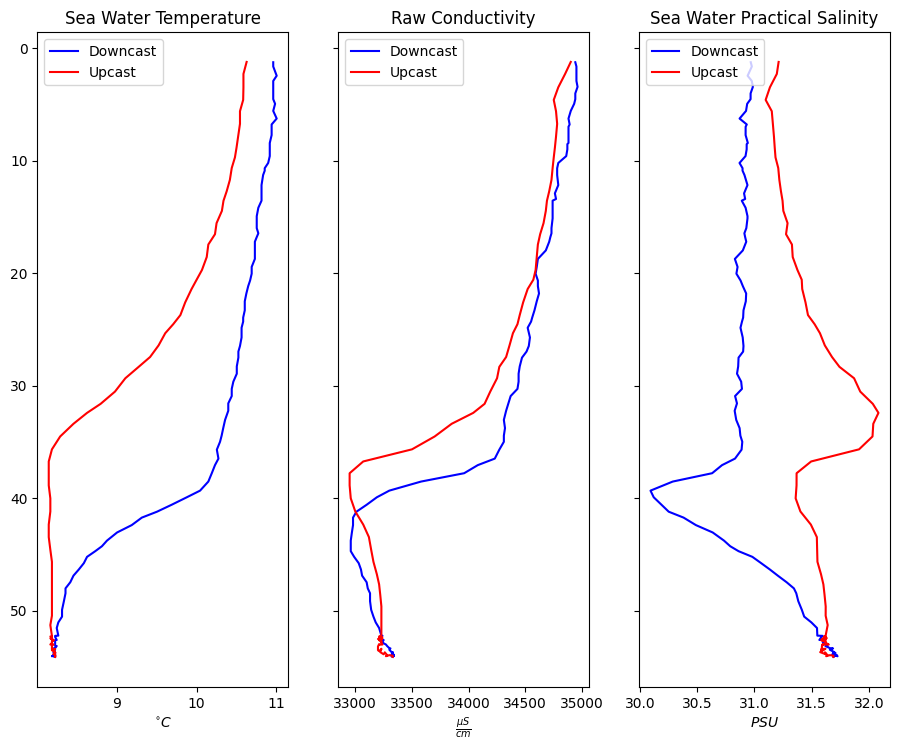

In [8]:
fig, ax = plt.subplots(1,3, figsize = (11,8.5), sharey = True)
ax[0].plot(down.sea_water_temperature, down.depth,label = 'Downcast', color = 'blue')
ax[0].plot(up.sea_water_temperature, up.depth,label = 'Upcast', color = 'red')
ax[0].legend(loc = 'upper left')
ax[0].set_title('Sea Water Temperature')
ax[0].set_xlabel(ds.sea_water_temperature.attrs['units_tex'])

ax[1].plot(down.conductivity, down.depth,label = 'Downcast', color = 'blue')
ax[1].plot(up.conductivity, up.depth,label = 'Upcast', color = 'red')
ax[1].legend(loc = 'upper left')
ax[1].set_title('Raw Conductivity')
ax[1].set_xlabel(ds.conductivity.attrs['units_tex'])

ax[2].plot(down.sea_water_practical_salinity, down.depth,label = 'Downcast', color = 'blue')
ax[2].plot(up.sea_water_practical_salinity, up.depth,label = 'Upcast', color = 'red')
ax[2].legend(loc = 'upper left')
ax[2].set_title('Sea Water Practical Salinity')
ax[2].set_xlabel(ds.sea_water_practical_salinity.attrs['units_tex'])


ax[-1].invert_yaxis()